<a href="https://colab.research.google.com/github/paulacca467/pub_selci/blob/main/teste4vazao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cartopy
!pip install cmocean

In [ ]:
#!/usr/bin/env python3.7
#coding: utf8
# Developed by: Paula Birocchi paula.birocchi@gmail.com
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import sys, os
sys.path.append('/content/drive/MyDrive/PUB_SELCI/scripts_for_ADCP')
sys.path.append('/content/drive/MyDrive/PUB_SELCI/scripts_for_ADCP/cmocean-master')
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.dates as mdates
import xarray as xr
import funcoes
import decomp
import scipy.io
import cmocean
import datetime as dt
import glob
import matplotlib as mpl
import numpy.matlib as npmat
from matplotlib.collections import PatchCollection
import coastline as fcoastline
import scipy.io as sci
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.dates import DateFormatter
from scipy.optimize import curve_fit
from datetime import datetime

def sine_function(x, A, omega, phi, C):
    return A * np.sin(omega * x + phi) + C
def tidal_curve(x, A_M2, phi_M2): #, A_M4, phi_M4, A_M6, phi_M6):
    M2 = A_M2 * np.cos(2 * np.pi / 12.42 * x + phi_M2)
    #M4 = A_M4 * np.cos(4 * np.pi / 6.21 * x + phi_M4)
    #M6 = A_M6 * np.cos(6 * np.pi / 4.14 * x + phi_M6)
    return M2 #+ M4 + M6
# load local coastline
# arquivo de polígonos separados por uma linha "       NaN       NaN"
coastline = np.loadtxt('/content/drive/MyDrive/PUB_SELCI/LC-Cananeia_2.txt')
loncoast1 = coastline[:,0]
latcoast1 = coastline[:,1]

In [7]:

fatias = {
        'C411912181101': [1, None],
    'C421912181133': [1, -2],
    'C431912181223': [1, -1],
    'C441912181300': [2, -2],
    'C451912181340': [3, -3],
    'C461912181508': [4, -3],
    'C471912181546': [3, -3],
    'C481912181621': [2, -3],
    'C491912181659': [2, -3],
    'C491912181705': [3, -5],
    'C491912181741': [2, -3],
    'C491912181855': [3, -2],
    'C491912181936': [3, -1],
    'C131912171124': [1, None],
    'C161912171636': [1, None],
    'C171912171808': [1, None],
    'C181912171935': [1, -1],
    'C191912172020': [1, None],
    'C191912172151': [2, None],
    'C11912170955': [None, -1],
    'C221912171057': [1, None],
    'C231912171148': [1, None],
    'C241912171248': [1, None],
    'C251912171603': [None, -2],
    'C261912171743': [4, -3],
    'C271912171835': [5, -3],
    'C281912171956': [3, -2],
    'C291912172113': [2, -3],
    'C291912172226': [5, -1],
    'C311912181043': [0, 2],
    'C321912181120': [0, 4],
    'C331912181209': [0, 5],
    'C341912181247': [2, 5],
    'C351912181320': [0, 2],
    'C361912181449': [1, 2],
    'C361912181454': [1, 4],
    'C371912181530': [0, 3],
    'C381912181604': [0, 3],
    'C391912181642': [0, 2],
    'C391912181645': [-3, None],
    # 'C391912181721': [0, 2],
    'C391912181830': [0, 3],
    'C391912181838': [0, 2],
    'C391912181920': [0, 5]
}


/tmp/ipython-input-2774533603.py:124: RuntimeWarning: Mean of empty slice
  vnplotmean = np.nanmean(vnplot,axis=0) ;
/tmp/ipython-input-2774533603.py:125: RuntimeWarning: Mean of empty slice
  veplotmean = np.nanmean(veplot,axis=0);


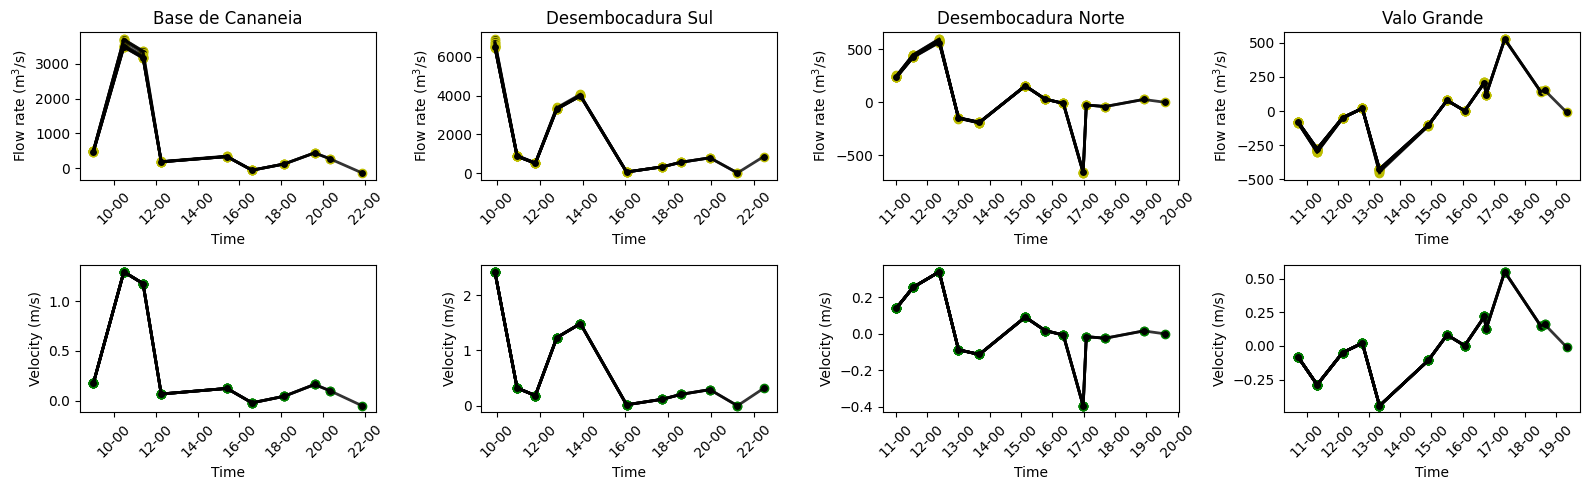

In [34]:
## GET DATA: ###
# Escolha o local do transecto:
locais = ['Base de Cananeia','Desembocadura Sul','Desembocadura Norte', 'Valo Grande'];
local = locais[0];

fig, axs = plt.subplots(2, 4, figsize=(16, 5), sharex=False, sharey=False)
date_form = DateFormatter("%H-%M")

## Abrindo pastas e definindo profundidade das celulas do ADP, lat e long para plot:
for i, local in enumerate(locais):
  if local  == 'Base de Cananeia':
          pasta2='/content/drive/MyDrive/PUB_SELCI/cananeia/campo_dezembro_2019/dados_ADCP/ADCP/ADCP_dados_selecionados/next_base_dados_selecionados/'
          latf = -25.016111
          lonf =  -47.922711
  if local  == 'Desembocadura Sul':
          pasta2='/content/drive/MyDrive/PUB_SELCI/cananeia/campo_dezembro_2019/dados_ADCP/ADCP/ADCP_dados_selecionados/desembocadura_cananeia_dados_selecionados/'
          z = np.arange(2,23);
          latf = -25.056857;
          lonf = -47.912767;
  if local == 'Desembocadura Norte':
          pasta2 ='/content/drive/MyDrive/PUB_SELCI/cananeia/campo_dezembro_2019/dados_ADCP/ADCP/ADCP_dados_selecionados/transversal_estuary_dados_selecionados/';
          z = np.arange(2,16);
          latf = -24.706237;
          lonf =  -47.543533;
  if local =='Valo Grande':
          pasta2 ='/content/drive/MyDrive/PUB_SELCI/cananeia/campo_dezembro_2019/dados_ADCP/ADCP/ADCP_dados_selecionados/river_valogrande_dados_selecionados/'
          z = np.arange(2,9);
          latf = -24.714309
          lonf = -47.564286

  decl_mag= -20.71;#Estuario de Cananeia Iguape dez/2019

  my_dirs = [d for d in os.listdir(pasta2) if os.path.isdir(os.path.join(pasta2, d))]
  my_dirs=sorted(my_dirs)
  vmedia=[];
  areatransectos=[]
  meddepmax=[]
  data_transectos=[]
  Vazao=[]

  for K in np.arange(0,len(my_dirs)):
    pasta = pasta2+my_dirs[K]+'/'+my_dirs[K]
    ## Bottom Track:
    bt=np.loadtxt(pasta+'.btk')
    #Pegando profundidade:
    prof = bt[:,1:4];
    # Fazendo média da profundidade dos 3 beams:
    medprof = np.nanmean(prof,axis=1)
    #Pegando velocidade U (leste-oeste) e V (norte-sul)  do bottom track:
    btu=bt[:,4];
    btv=bt[:,5];
    ##GPS :
    gps = np.loadtxt(pasta+'.gps')
    #Pegando velocidade U (leste-oeste) e V (norte-sul)  do GPS:
    gpsu=gps[:,7];
    gpsv=gps[:,8];
    #Pegando velocidade U e V medidas pelo ADP:
    ve = np.loadtxt(pasta+'.ve')
    vn = np.loadtxt(pasta+'.vn')
    # removendo primeira coluna (referente ao numero do perfil):
    ve = ve[:,1:];
    vn=vn[:,1:];
    # removendo valores espurios do fundo oceanico:
    ve[ve==3276.7]=np.nan;
    vn[vn==3276.7]=np.nan;
    # passando para m/s:
    ve = ve/100;
    vn = vn/100;

    nome_transecto = my_dirs[K]
    regra = fatias.get(nome_transecto)


    if regra:
      start, end = regra

      ve = ve[start:end, :]
      vn = vn[start:end, :]
      medprof = medprof[start:end]
      btu = btu[start:end]
      btv = btv[start:end]
      gpsu = gpsu[start:end]
      gpsv = gpsv[start:end]


    if nome_transecto == 'C271912171835':
      pass

    if nome_transecto == 'C391912181721':

      indices_desejados = [0, 2]
      ve = ve[indices_desejados, :]
      vn = vn[indices_desejados, :]
      medprof = medprof[indices_desejados]
      btu = btu[indices_desejados]
      btv = btv[indices_desejados]
      gpsu = gpsu[indices_desejados]
      gpsv = gpsv[indices_desejados]

    ########### Application of Method of Joyce (1989):###############
    #tan(alpha) =< ubt*vsh - vbt*ush>/<ubt*ush + vbt*vsh>
    #1 + beta  = [<ush^2 + vsh^2>/<ubt^2+ vbt^2>]^1/2
    arco=np.nanmean((btu * gpsv) - (btv * gpsu))/np.nanmean((btu * gpsu) + (btv * gpsv)); # right side of equation for alpha
    alpha = np.arctan(arco); # em radianos!
    rightbeta = np.sqrt(np.nanmean(gpsu**2 + gpsv**2)/np.nanmean(btu**2 + btv**2)) # right side of equation for beta
    beta = rightbeta - 1; # em radianos!
    # Corrigindo velocidades U e V (ve e vn):
    veori = ve; # velocidade leste-oeste original ADP
    vnori = vn; # velocidade norte-sul original ADP
    #ucorr = [1 + beta] *[u *cos(alpha)  - v *sin(alpha) ]
    #vcorr = [1 + beta ]* [u *sin (alpha) + v *cos(alpha) ]
    ve = (1 + beta) * (veori*np.cos(alpha) - vnori *np.sin(alpha));
    vn = (1 + beta) * (veori*np.sin(alpha) - vnori*np.cos(alpha));
    # Calcula magnitude e direcao com declinacao magnetica:
    mag = np.zeros(ve.shape)*np.nan;
    direcao = np.zeros(ve.shape)*np.nan;
    for m in np.arange(0,ve.shape[0]):
      for n in np.arange(0,ve.shape[1]):
        mag[m,n],direcao[m,n] = decomp.uv2intdir(ve[m,n],vn[m,n],decl_mag,0);

    #calcula VE e VN com declinacao magnetica para plot:
    veplot,vnplot = decomp.intdir2uv(mag,direcao,0,0);
    # Calcula velocidade media para cada celula (profundidade):
    vnplotmean = np.nanmean(vnplot,axis=0) ;
    veplotmean = np.nanmean(veplot,axis=0);

    # Removendo nans (valores no fundo)
    vnplotmean = vnplotmean[~np.isnan(vnplotmean)]
    veplotmean = veplotmean[~np.isnan(veplotmean)]
    # Calcula velocidade média no transecto no total:
    vnplotmean2 = np.nanmean(vnplotmean);
    veplotmean2=np.nanmean(veplotmean);
    vmedia =np.append(vmedia,vnplotmean2);
    # Distancia horizontal entre as margens: 204 metros (google maps)
    distanciamargens = 204 ;
    meddep = np.nanmean(prof,axis=1);
    meddepmax=np.append(meddepmax,np.nanmax(meddep));
    tamanhocelula=204/len(meddep); # tamanho de cada célula do ADP:
    areascelulas=meddep*tamanhocelula; # area de cada celula
    areatotaltransecto=np.nansum(areascelulas) # area total
    areatransectos=np.append(areatransectos,areatotaltransecto);
  #areaantiga = 444.3934; # Valo Grande
    areafinal= np.nanmean(areatransectos)
    Vazao = areafinal*vmedia;
    Vazaomedia = np.nanmean(Vazao)

    #pega os ultimos 10 digitos do nome do arquivo (ano, mes, dia, hora, minuto)
    nome_diretorio = my_dirs[K]
    timestamp_str = nome_diretorio[-10:]
    #if len(nome_diretorio) == 12:
      #timestamp_str = nome_diretorio[2:]
    #elif len(nome_diretorio) == 13:
      #timestamp_str = nome_diretorio[3:]
  # else:
    # timestamp_str = nome_diretorio[4:]

    data_hora_atual = datetime.strptime(timestamp_str, '%y%m%d%H%M')
    data_transectos.append(data_hora_atual)
    #DateTime =np.array(['2019-12-18T10:43:00', '2019-12-18T11:20:00','2019-12-18T12:09:00','2019-12-18T12:47:00','2019-12-18T13:20:00','2019-12-18T14:54:00','2019-12-18T15:30:00','2019-12-18T16:04:00','2019-12-18T16:42:00','2019-12-18T16:45:00','2019-12-18T17:21:00','2019-12-18T18:30:00','2019-12-18T18:38:00', '2019-12-18T19:20:00'],dtype= 'datetime64')


    ax1 = axs[0, i]
    ax1.scatter(data_transectos, Vazao, c='k', edgecolor='y')
    ax1.plot(data_transectos, Vazao, 'k', linewidth=2, alpha=0.8)
    ax1.set_title(local.replace('_', '\n'))
    ax1.set_xlabel('Time')
    ax1.set_ylabel(r'Flow rate (m$^{3}$/s)')
    ax1.xaxis.set_major_formatter(date_form)
    ax1.tick_params(axis='x', rotation=45)


    ax2 = axs[1, i]
    ax2.scatter(data_transectos, vmedia, c='k', edgecolor='g')
    ax2.plot(data_transectos, vmedia, 'k', linewidth=2, alpha=0.8)
    ax2.set_xlabel('Time')
    ax2.set_ylabel(r'Velocity (m/s)')
    ax2.xaxis.set_major_formatter(date_form)
    ax2.tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

In [26]:
print(local, len(Vazao))

valogrande 14


/tmp/ipython-input-3147016675.py:91: RuntimeWarning: Mean of empty slice
  vnplotmean = np.nanmean(vnplot,axis=0) ;
/tmp/ipython-input-3147016675.py:92: RuntimeWarning: Mean of empty slice
  veplotmean = np.nanmean(veplot,axis=0);


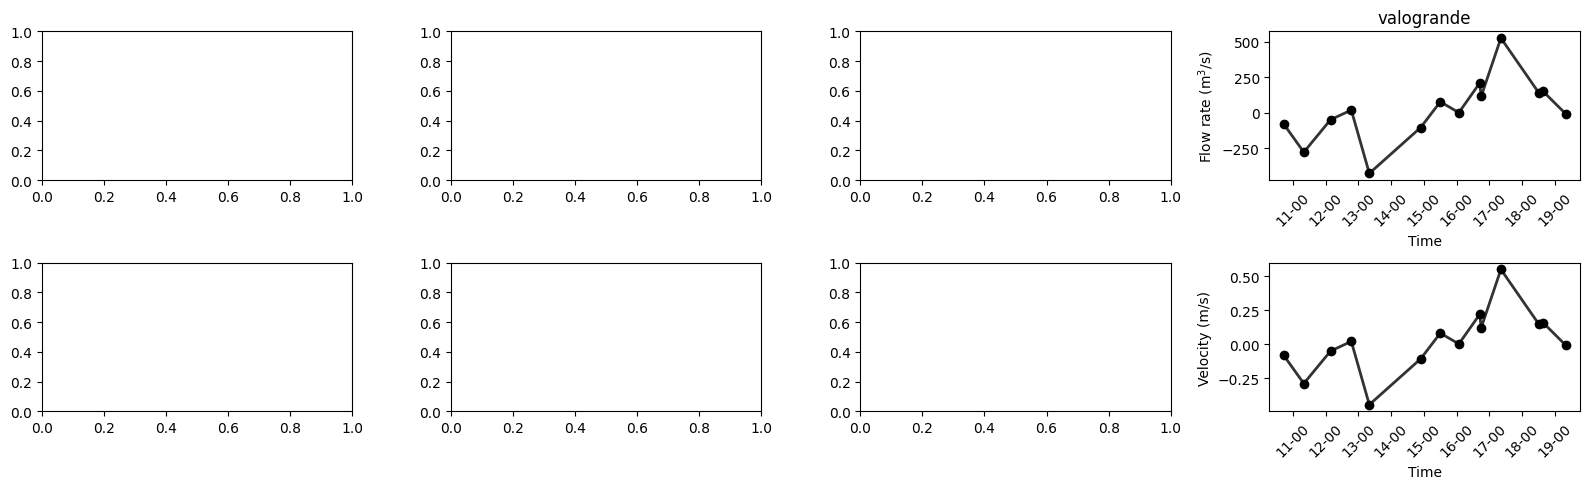

In [11]:
# @title
  my_dirs = [d for d in os.listdir(pasta2) if os.path.isdir(os.path.join(pasta2, d))]
  my_dirs=sorted(my_dirs)
  vmedia=[];
  areatransectos=[]
  meddepmax=[]
  data_transectos=[]

  for K in np.arange(0,len(my_dirs)):
    pasta = pasta2+my_dirs[K]+'/'+my_dirs[K]
    ## Bottom Track:
    bt=np.loadtxt(pasta+'.btk')
    #Pegando profundidade:
    prof = bt[:,1:4];
    # Fazendo média da profundidade dos 3 beams:
    medprof = np.nanmean(prof,axis=1)
    #Pegando velocidade U (leste-oeste) e V (norte-sul)  do bottom track:
    btu=bt[:,4];
    btv=bt[:,5];
    ##GPS :
    gps = np.loadtxt(pasta+'.gps')
    #Pegando velocidade U (leste-oeste) e V (norte-sul)  do GPS:
    gpsu=gps[:,7];
    gpsv=gps[:,8];
    #Pegando velocidade U e V medidas pelo ADP:
    ve = np.loadtxt(pasta+'.ve')
    vn = np.loadtxt(pasta+'.vn')
    # removendo primeira coluna (referente ao numero do perfil):
    ve = ve[:,1:];
    vn=vn[:,1:];
    # removendo valores espurios do fundo oceanico:
    ve[ve==3276.7]=np.nan;
    vn[vn==3276.7]=np.nan;
    # passando para m/s:
    ve = ve/100;
    vn = vn/100;

    nome_transecto = my_dirs[K]
    regra = fatias.get(nome_transecto)


    if regra:
      start, end = regra

      ve = ve[start:end, :]
      vn = vn[start:end, :]
      medprof = medprof[start:end]
      btu = btu[start:end]
      btv = btv[start:end]
      gpsu = gpsu[start:end]
      gpsv = gpsv[start:end]


    if nome_transecto == 'C271912171835':
      pass

    if nome_transecto == 'C391912181721':

      indices_desejados = [0, 2]
      ve = ve[indices_desejados, :]
      vn = vn[indices_desejados, :]
      medprof = medprof[indices_desejados]
      btu = btu[indices_desejados]
      btv = btv[indices_desejados]
      gpsu = gpsu[indices_desejados]
      gpsv = gpsv[indices_desejados]

    ########### Application of Method of Joyce (1989):###############
    #tan(alpha) =< ubt*vsh - vbt*ush>/<ubt*ush + vbt*vsh>
    #1 + beta  = [<ush^2 + vsh^2>/<ubt^2+ vbt^2>]^1/2
    arco=np.nanmean((btu * gpsv) - (btv * gpsu))/np.nanmean((btu * gpsu) + (btv * gpsv)); # right side of equation for alpha
    alpha = np.arctan(arco); # em radianos!
    rightbeta = np.sqrt(np.nanmean(gpsu**2 + gpsv**2)/np.nanmean(btu**2 + btv**2)) # right side of equation for beta
    beta = rightbeta - 1; # em radianos!
    # Corrigindo velocidades U e V (ve e vn):
    veori = ve; # velocidade leste-oeste original ADP
    vnori = vn; # velocidade norte-sul original ADP
    #ucorr = [1 + beta] *[u *cos(alpha)  - v *sin(alpha) ]
    #vcorr = [1 + beta ]* [u *sin (alpha) + v *cos(alpha) ]
    ve = (1 + beta) * (veori*np.cos(alpha) - vnori *np.sin(alpha));
    vn = (1 + beta) * (veori*np.sin(alpha) - vnori*np.cos(alpha));
    # Calcula magnitude e direcao com declinacao magnetica:
    mag = np.zeros(ve.shape)*np.nan;
    direcao = np.zeros(ve.shape)*np.nan;
    for m in np.arange(0,ve.shape[0]):
      for n in np.arange(0,ve.shape[1]):
        mag[m,n],direcao[m,n] = decomp.uv2intdir(ve[m,n],vn[m,n],decl_mag,0);

    #calcula VE e VN com declinacao magnetica para plot:
    veplot,vnplot = decomp.intdir2uv(mag,direcao,0,0);
    # Calcula velocidade media para cada celula (profundidade):
    vnplotmean = np.nanmean(vnplot,axis=0) ;
    veplotmean = np.nanmean(veplot,axis=0);

    # Removendo nans (valores no fundo)
    vnplotmean = vnplotmean[~np.isnan(vnplotmean)]
    veplotmean = veplotmean[~np.isnan(veplotmean)]
    # Calcula velocidade média no transecto no total:
    vnplotmean2 = np.nanmean(vnplotmean);
    veplotmean2=np.nanmean(veplotmean);
    vmedia =np.append(vmedia,vnplotmean2);
    # Distancia horizontal entre as margens: 204 metros (google maps)
    distanciamargens = 204 ;
    meddep = np.nanmean(prof,axis=1);
    meddepmax=np.append(meddepmax,np.nanmax(meddep));
    tamanhocelula=204/len(meddep); # tamanho de cada célula do ADP:
    areascelulas=meddep*tamanhocelula; # area de cada celula
    areatotaltransecto=np.nansum(areascelulas) # area total
    areatransectos=np.append(areatransectos,areatotaltransecto);
  #areaantiga = 444.3934; # Valo Grande
    areafinal= np.nanmean(areatransectos)
    Vazao = areafinal*vmedia;
    Vazaomedia = np.nanmean(Vazao)

    #pega os ultimos 10 digitos do nome do arquivo (ano, mes, dia, hora, minuto)
    nome_diretorio = my_dirs[K]
    timestamp_str = nome_diretorio[-10:]
    #if len(nome_diretorio) == 12:
      #timestamp_str = nome_diretorio[2:]
    #elif len(nome_diretorio) == 13:
      #timestamp_str = nome_diretorio[3:]
  # else:
    # timestamp_str = nome_diretorio[4:]

    data_hora_atual = datetime.strptime(timestamp_str, '%y%m%d%H%M')
    data_transectos.append(data_hora_atual)
    #DateTime =np.array(['2019-12-18T10:43:00', '2019-12-18T11:20:00','2019-12-18T12:09:00','2019-12-18T12:47:00','2019-12-18T13:20:00','2019-12-18T14:54:00','2019-12-18T15:30:00','2019-12-18T16:04:00','2019-12-18T16:42:00','2019-12-18T16:45:00','2019-12-18T17:21:00','2019-12-18T18:30:00','2019-12-18T18:38:00', '2019-12-18T19:20:00'],dtype= 'datetime64')

  fig, axs = plt.subplots(2, 4, figsize=(16, 5), sharex=False, sharey=False)
  date_form = DateFormatter("%H-%M")

  ax1 = axs[0, i]
  ax1.scatter(data_transectos, Vazao, c='k')
  ax1.plot(data_transectos, Vazao, 'k', linewidth=2, alpha=0.8)
  ax1.set_title(local.replace('_', '\n'))
  ax1.set_xlabel('Time')
  ax1.set_ylabel(r'Flow rate (m$^{3}$/s)')
  ax1.xaxis.set_major_formatter(date_form)
  ax1.tick_params(axis='x', rotation=45)

    # ======== PLOT 2: Velocidade média ========
  ax2 = axs[1, i]
  ax2.scatter(data_transectos, vmedia, c='k')
  ax2.plot(data_transectos, vmedia, 'k', linewidth=2, alpha=0.8)
  ax2.set_xlabel('Time')
  ax2.set_ylabel(r'Velocity (m/s)')
  ax2.xaxis.set_major_formatter(date_form)
  ax2.tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()


In [ ]:
# @title
# Predict next three hours of data using a adjust curve in the data to be able to get a complete tidal cycle
# Get time data in numbers:
x_data=mdates.date2num(data_transectos)
# normalizar para iniciar em zero:
x_norm = x_data - np.nanmin(x_data)
# intervalo para novos valores:
interv_new = (x_norm[-1]-x_norm[-2])
# Create x-values for prediction (next 3 points)
x_predict = np.array([(np.nanmax(x_norm)+interv_new),(np.nanmax(x_norm)+(2*interv_new)),(np.nanmax(x_norm)+ (3*interv_new))])
# Adjust curve for velocity and discharge
popveloci, _ = curve_fit(sine_function, x_norm, vmedia)
# Predict 3 new values:
y_predict_veloci = sine_function(x_predict, *popveloci)

popdis, _ = curve_fit(sine_function, x_norm, vmedia)
popdis[0]= popdis[0]*1500
y_predict_dis = sine_function(x_predict, *popdis)

plt.figure(figsize=(10, 6))
plt.scatter(x_norm, vmedia, label='Velocity', color='blue')
plt.plot(x_norm, sine_function(x_norm, *popveloci), label='Fitted Sine Curve', color='red')
plt.scatter(x_predict, y_predict_veloci, label='Predicted Velocity Points', color='green', marker='x')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.suptitle(local)
plt.title('Fitting a Sine Curve and Predicting Next 3 Points')
plt.grid(True)
plt.savefig('previsao_velocidade_' + str(local) + '_python_joyce_correction_areacorrigida.png', bbox_inches='tight',dpi=1000)

plt.figure(figsize=(10, 6))
plt.scatter(x_norm, Vazao, label='Discharge', color='blue')
plt.plot(x_norm, sine_function(x_norm, *popdis), label='Fitted Sine Curve', color='red')
plt.scatter(x_predict, y_predict_dis, label='Predicted Discharge Points', color='green', marker='x')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.suptitle(local)
plt.title('Fitting a Sine Curve and Predicting Next 3 Points')
plt.grid(True)
plt.savefig('previsao_vazao_'+ str(local) + '_python_joyce_correction_areacorrigida.png', bbox_inches='tight',dpi=1000)

In [ ]:
#!zip graficos.zip *.png